Unsupervised learning in trading involves using ML techniques to analyse data and discover patterns, relationships, and structures within the data without any pre-defined label or target variable. 

Unsupervised learning has multiple applications to trading
- clustering 
- dimensionality reduction 
- anomaly detection
- market regime detection 
- portfolio optimization 

Our plan for this project:
 - Download SP500 stocks prices data
 - Calculate different technical indicators and features for each stock 
 - Aggregate monthly and filter only top 150 most liquid stocks for each month
 - Calculate monthly returns for different time horizons 
 - Use Fama-French Factors to calculate rolling betas for each stock 
 - Train a K-Means model for each month to cluster similar stocks together
 - For each month, select assets based on a cluster and form a portfolio using Efficient Frontier max sharpe ratio portfolio optimisation 
 - Visualise portfolio returns and compare with SP500 

=> LIMITATION: We are using only the most recent SP500 stocks list and therefore suffer from the surviviorship bias. We should use surviviorship free data. 

### 1. Downloading Data

In [440]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df


[*********************100%%**********************]  502 of 502 completed

3 Failed downloads:
['VLTO', 'SOLV', 'GEV']: YFChartError("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")


Price               adj close       close  ...        open       volume
date       ticker                          ...                         
2015-09-29 A        31.972824   33.740002  ...   33.360001    2252400.0
           AAL      37.361622   39.180000  ...   39.049999    7478800.0
           AAPL     25.072458   27.264999  ...   28.207500  293461600.0
           ABBV     39.034489   52.790001  ...   53.099998   12842800.0
           ABT      34.938995   39.500000  ...   39.259998   12287500.0
...                       ...         ...  ...         ...          ...
2023-09-26 XYL      89.519997   89.519997  ...   90.379997    1322400.0
           YUM     124.010002  124.010002  ...  124.239998    1500600.0
           ZBH     112.459999  112.459999  ...  116.769997    3610500.0
           ZBRA    223.960007  223.960007  ...  225.970001     355400.0
           ZTS     176.869995  176.869995  ...  176.580002    1463200.0

[985955 rows x 6 columns]

### 2. Calculating features and techical indicators for each stock

For each stock, we will compute the following metrics:
 - Garman-Klass volatility
 - RSI
 - Bollinger Bands
 - ATR
 - MACD
 - Dollar volume

In [441]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close  ...      macd  dollar_volume
date       ticker                          ...                         
2015-09-29 A        31.972824   33.740002  ...       NaN      72.015589
           AAL      37.361622   39.180000  ...       NaN     279.420098
           AAPL     25.072458   27.264999  ...       NaN    7357.803719
           ABBV     39.034489   52.790001  ...       NaN     501.312131
           ABT      34.938995   39.500000  ...       NaN     429.312906
...                       ...         ...  ...       ...            ...
2023-09-26 XYL      89.519997   89.519997  ... -2.161610     118.381244
           YUM     124.010002  124.010002  ... -1.398680     186.089409
           ZBH     112.459999  112.459999  ... -0.871637     406.036827
           ZBRA    223.960007  223.960007  ... -1.600791      79.595386
           ZTS     176.869995  176.869995  ... -1.179329     258.796177

[985955 rows x 14 columns]

### 3. Aggregate on a monthly level and select top 150 most liquid stocks 

We do this aggregation to reduce treining time and therefore facilitate the experimentation with different features and strategies.

In [442]:
# Create a table containing only aggregates of those metrics we calculated + those that can be aggregated. 

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]
# dollar_volume is aggregated based on its mean over a month. All others use the value at a month's end 
# as the value for this month.
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

# Calculating dollar_volume 5-year rolling average for each stock before selecting

data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol  ...       atr      macd
date       ticker                                ...                    
2016-10-31 AAL      39.134323         -0.000176  ...  0.402199  1.131595
           AAPL     26.660484         -0.001524  ... -1.038688 -0.192621
           ABBV     43.235226         -0.029345  ... -0.893132 -0.741807
           ABT      35.789295         -0.003592  ... -1.035224 -0.644463
           ACN     107.176559         -0.002182  ... -0.996806 -0.128926
...                       ...               ...  ...       ...       ...
2023-09-30 XOM     116.410004          0.000045  ...  0.601335  1.289669
           MRNA     98.120003          0.000146  ... -0.529511 -0.376899
           UBER     44.270000          0.000441  ... -0.746098 -0.133973
           CRWD    160.479996          0.000144  ... -0.744862  0.245950
           ABNB    132.279999          0.000213  ... -1.006939 -0.037854

[12516 rows x 8 columns]

### 4. Calculate monthly returns over different time horizons and add them as features

We do this in order to reflect different time series dynamics which reflect the momentum patterns for each stock. We will compute over 1 month, 2 months, 3 months, 6 months, 9 months, and 12 months

In [443]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol  ...  return_9m  return_12m
date       ticker                                ...                       
2017-10-31 AAL      45.534168         -0.000363  ...   0.007008    0.012702
           AAPL     40.392677         -0.000441  ...   0.038941    0.035228
           ABBV     72.505547         -0.019517  ...   0.047273    0.044026
           ABT      50.608589         -0.002055  ...   0.031320    0.029294
           ACN     133.906219         -0.001701  ...   0.027398    0.018728
...                       ...               ...  ...        ...         ...
2023-09-30 XOM     116.410004          0.000045  ...   0.006008    0.024261
           MRNA     98.120003          0.000146  ...  -0.064976   -0.015431
           UBER     44.270000          0.000441  ...   0.066838    0.043691
           CRWD    160.479996          0.000144  ...   0.047942   -0.002216
           ABNB    132.279999          0.000213  ...   0.049124    0.019401

[10341 rows x 14 columns]

### 5. Download the Fama-French factors and compute rolling factors betas

 - We will introduce the Fama-French to compute the exposure the exposure of assets to common risk factors using linear regression. 
 - The 5 Fama-French factors are:
    - market risk
    - size
    - value 
    - operating profitability
    - investment 

=> They have been shown to explain asset returns and are commonly used to assess the risk/return profile of portfolios. 

In [444]:
# Downloading Fama-French factors.
# For the scope of this project, we are ignoing risk-free rate. This should 
# not be a done in a strategy that is intended to be implemented. 
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
               "famafrench",
               start = "2010")[0].drop("Mkt-RF",axis=1)

factor_data.index = factor_data.index.to_timestamp()

# Aligns the factors with our data that is recorded for the end of a month and not the beginning. 
# The data is expressed as a %, we want it as a plain decimal and therefore convert. 
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'

"""
We associate the Fama-French factors which are said to be predictive with the return over 1 month and will conduct 
linear regression to compute beta.
"""
factor_data = factor_data.join(data['return_1m']).sort_index()
# filter_out stocks with less than 10 monhts of data
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

# Computing rolling factor betas

betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))


factors = ['RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))
# Inputing all unknown values from the factor's average.

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

""" 
Our final dataframe has structure:
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   garman-klass volatility  10456 non-null  float64
 1   rsi                      10456 non-null  float64
 2   bb_low                   10456 non-null  float64
 3   bb_mid                   10456 non-null  float64
 4   bb_high                  10456 non-null  float64
 5   atr                      10456 non-null  float64
 6   macd                     10456 non-null  float64
 7   return_1m                10456 non-null  float64
 8   return_2m                10456 non-null  float64
 9   return_3m                10456 non-null  float64
 10  return_6m                10456 non-null  float64
 11  return_9m                10456 non-null  float64
 12  return_12m               10456 non-null  float64
 13  SMB                      10166 non-null  float64
 14  HML                      10166 non-null  float64
 15  RMW                      10166 non-null  float64
 16  CMA                      10166 non-null  float64
 17  RF                       10166 non-null  float64
dtypes: float64(18)
"""


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10117 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'CRWD')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10117 non-null  float64
 1   rsi               10117 non-null  float64
 2   bb_low            10117 non-null  float64
 3   bb_mid            10117 non-null  float64
 4   bb_high           10117 non-null  float64
 5   atr               10117 non-null  float64
 6   macd              10117 non-null  float64
 7   return_1m         10117 non-null  float64
 8   return_2m         10117 non-null  float64
 9   return_3m         10117 non-null  float64
 10  return_6m         10117 non-null  float64
 11  return_9m         10117 non-null  float64
 12  return_12m        10117 non-null  float64
 13  SMB               10117 non-null  float64
 14  HML               10117 non-null  float64
 15  RMW       

' \nOur final dataframe has structure:\n #   Column                   Non-Null Count  Dtype  \n---  ------                   --------------  -----  \n 0   garman-klass volatility  10456 non-null  float64\n 1   rsi                      10456 non-null  float64\n 2   bb_low                   10456 non-null  float64\n 3   bb_mid                   10456 non-null  float64\n 4   bb_high                  10456 non-null  float64\n 5   atr                      10456 non-null  float64\n 6   macd                     10456 non-null  float64\n 7   return_1m                10456 non-null  float64\n 8   return_2m                10456 non-null  float64\n 9   return_3m                10456 non-null  float64\n 10  return_6m                10456 non-null  float64\n 11  return_9m                10456 non-null  float64\n 12  return_12m               10456 non-null  float64\n 13  SMB                      10166 non-null  float64\n 14  HML                      10166 non-null  float64\n 15  RMW                 

### 6. Clustering our stocks using KMeans Clustering

In [445]:
from sklearn.cluster import  KMeans

# We intialise cluster centroids to have specific RSI values. This enables us to easily interpret the cluster 
# number across all months. 
target_rsi_values = [30, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

from sklearn.cluster import KMeans

# data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=2,
                           random_state=42,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi  ...         RF  cluster
date       ticker                               ...                    
2017-10-31 AAL            -0.000363  41.051783  ...  -4.609064        0
           AAPL           -0.000441  69.196677  ... -14.290689        1
           ABBV           -0.019517  55.247841  ... -11.914038        1
           ABT            -0.002055  53.844916  ...   4.500314        0
           ACN            -0.001701  69.365441  ...  -4.880016        0
...                             ...        ...  ...        ...      ...
2023-09-30 WMT             0.000024  54.364954  ...   5.056809        0
           XOM             0.000045  58.898191  ...  -1.436984        0
           MRNA            0.000146  38.747314  ...   6.595535        1
           UBER            0.000441  45.005268  ...  20.369260        1
           CRWD            0.000144  51.534803  ...  -1.645899        0

[10117 rows x 19 columns]

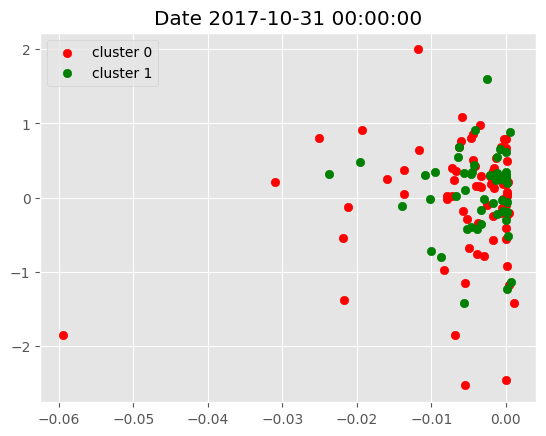

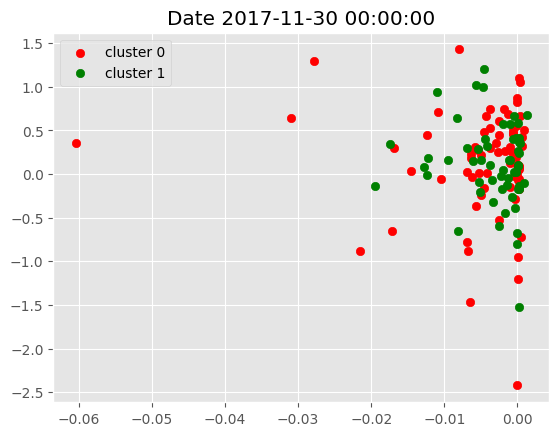

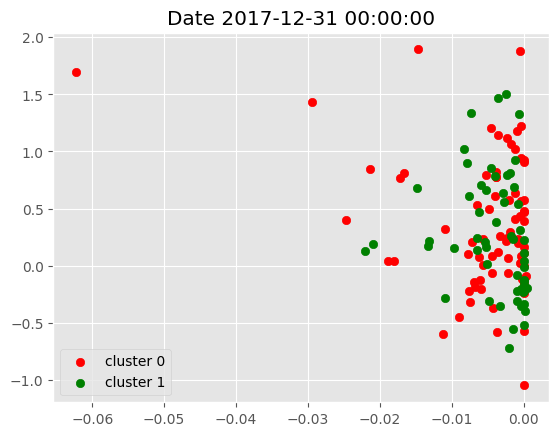

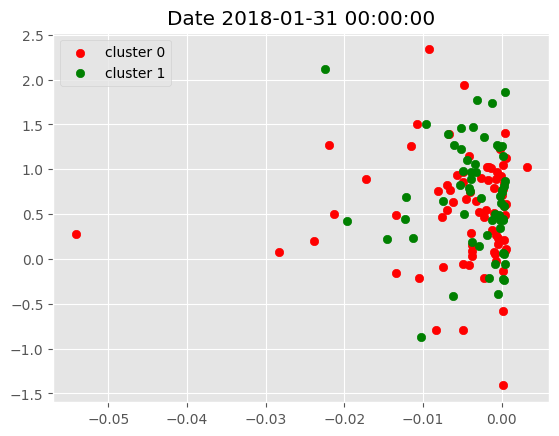

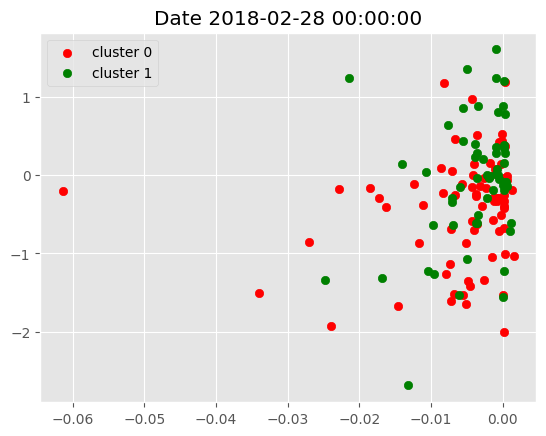

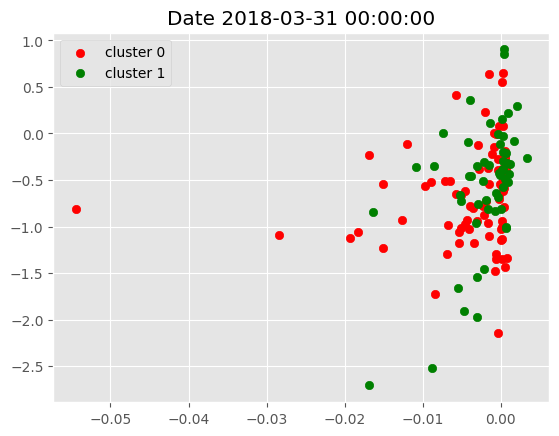

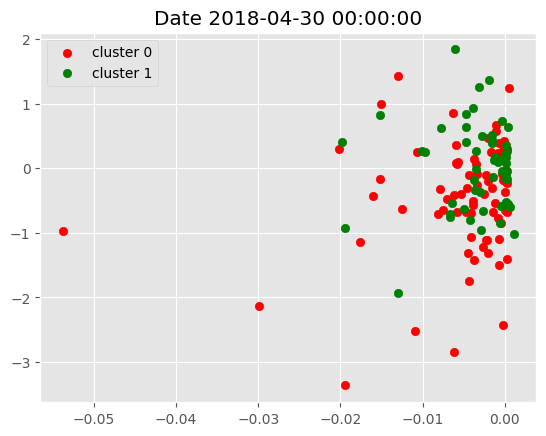

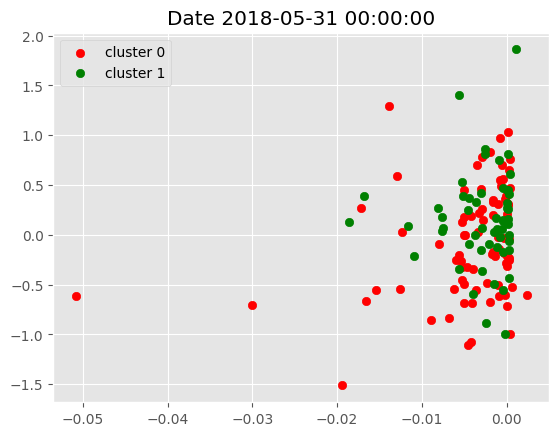

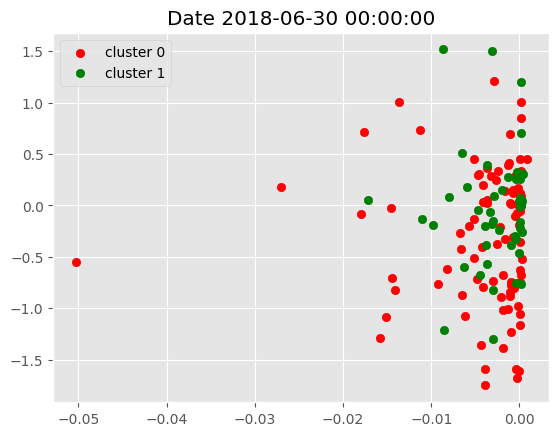

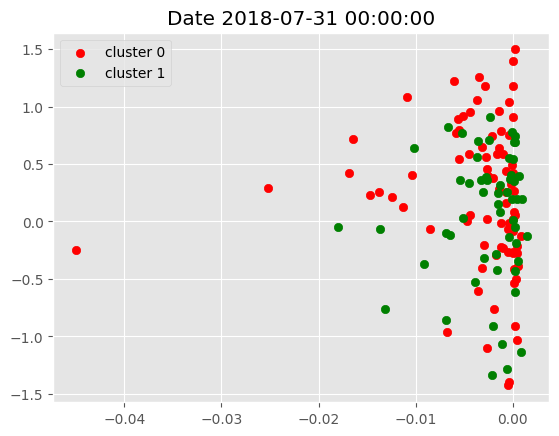

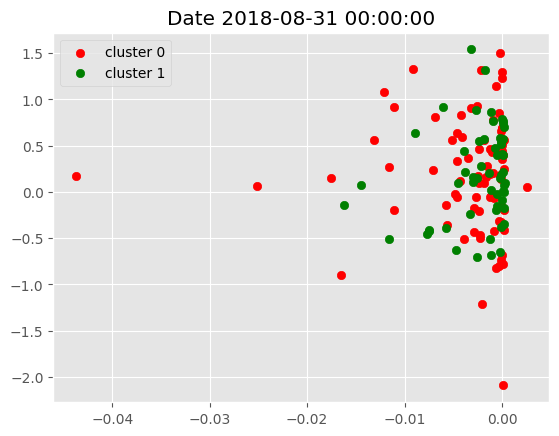

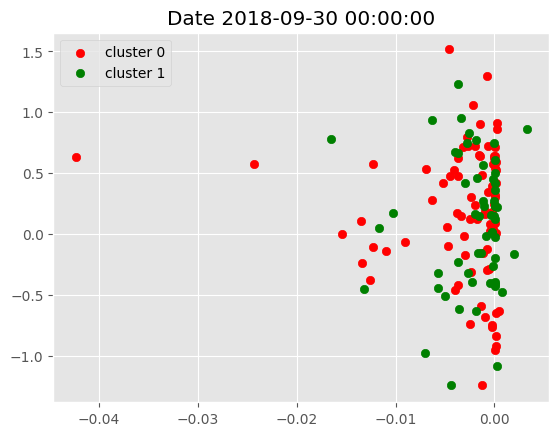

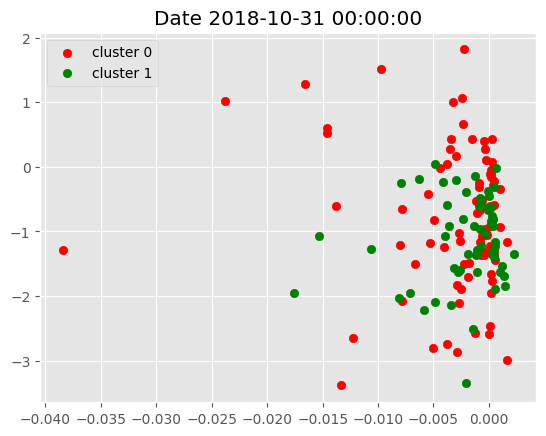

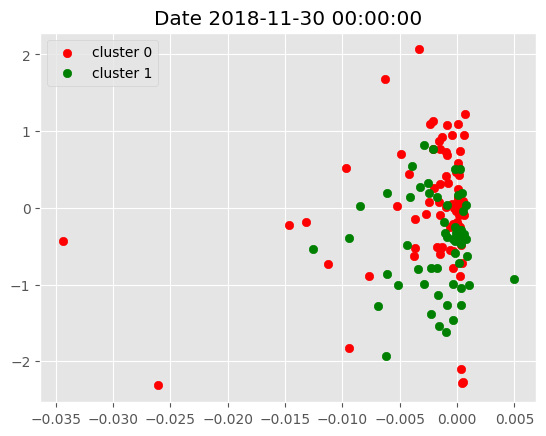

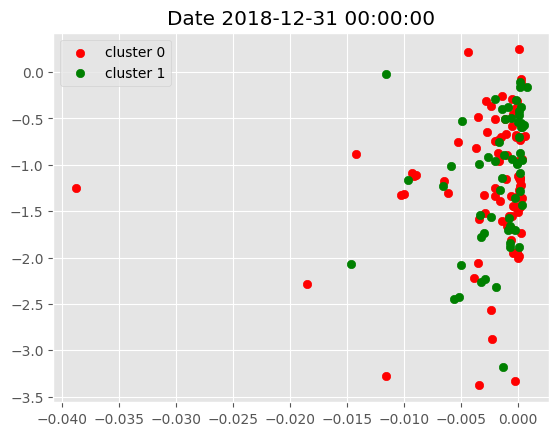

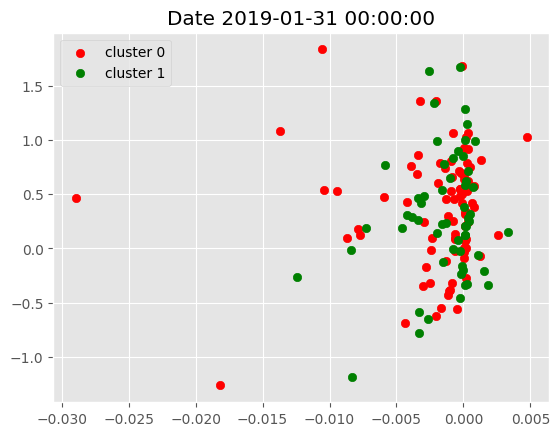

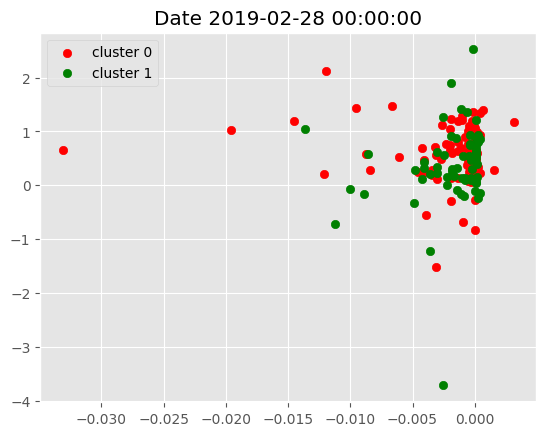

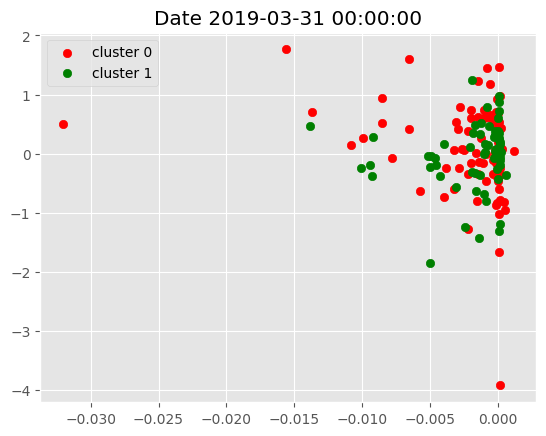

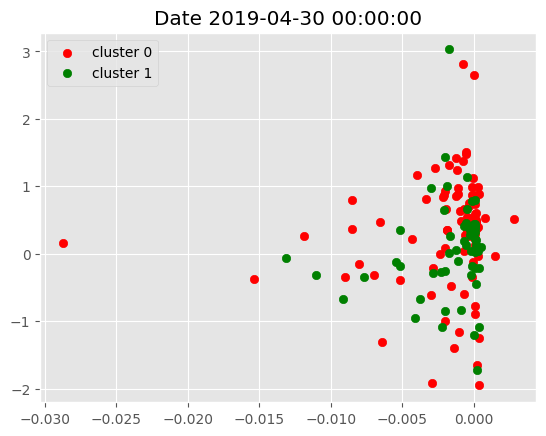

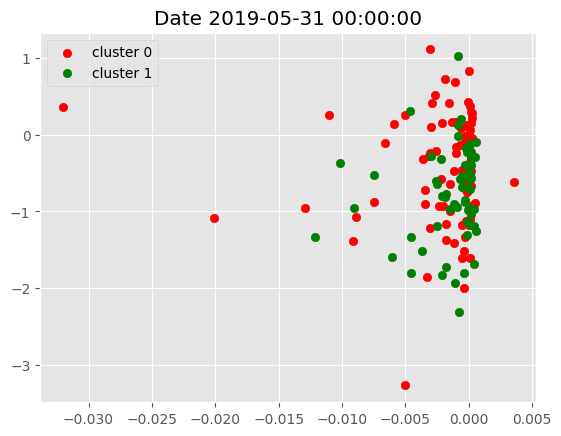

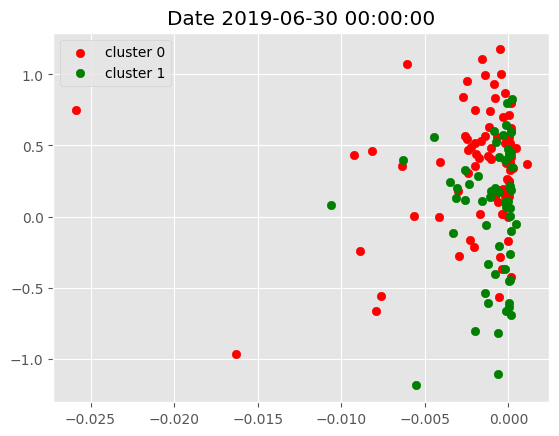

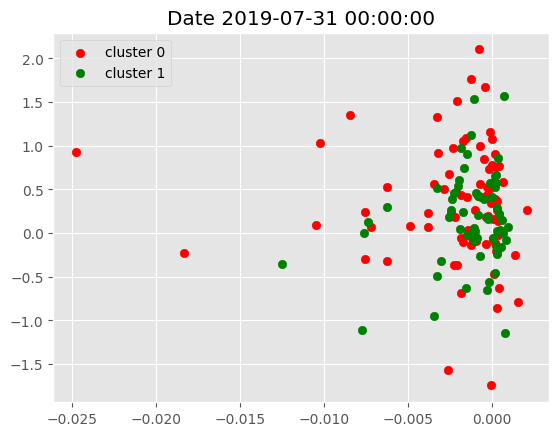

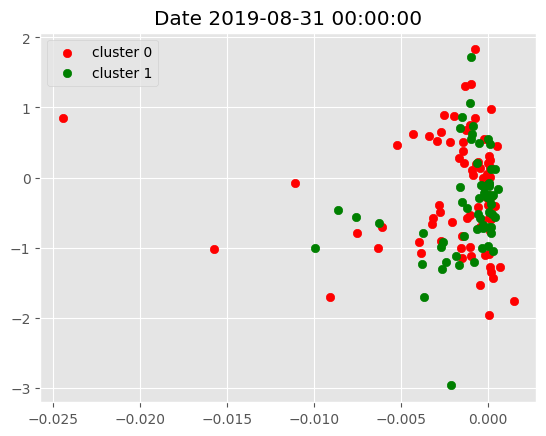

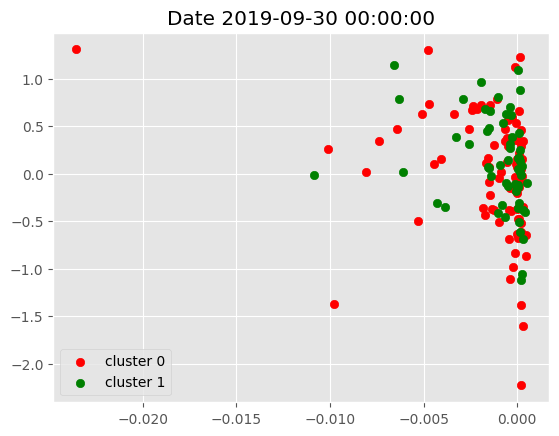

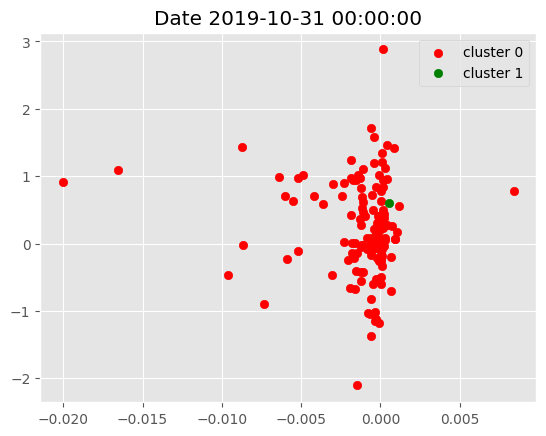

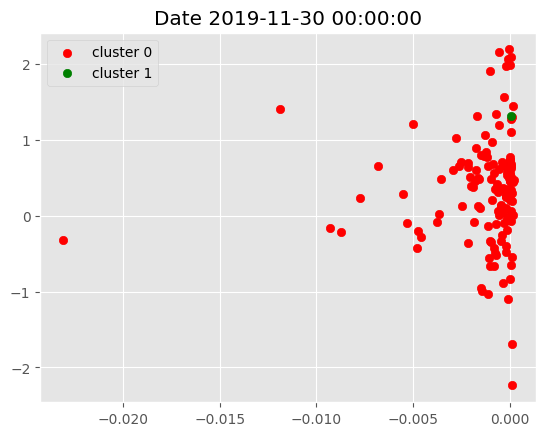

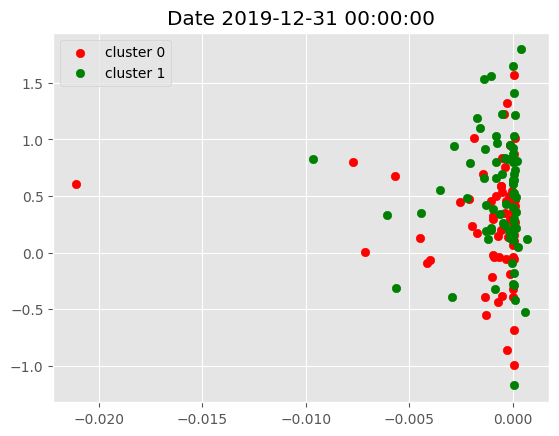

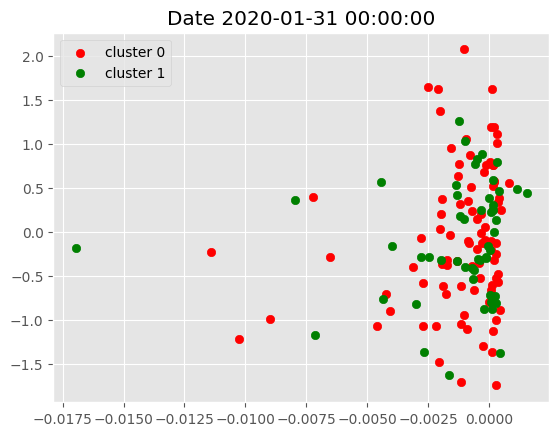

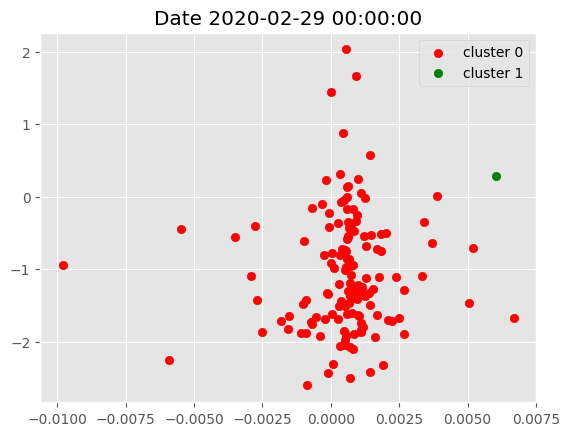

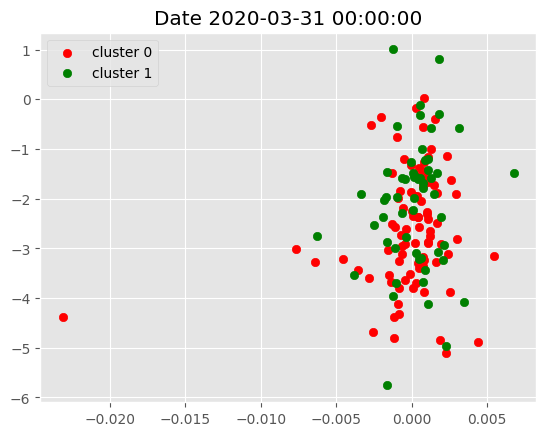

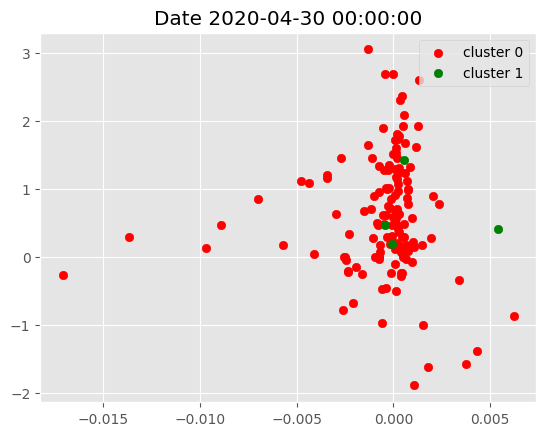

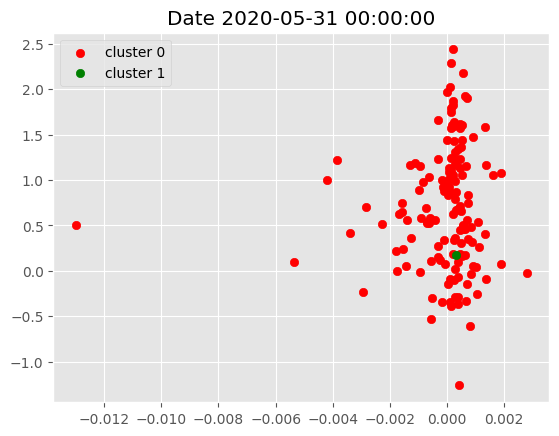

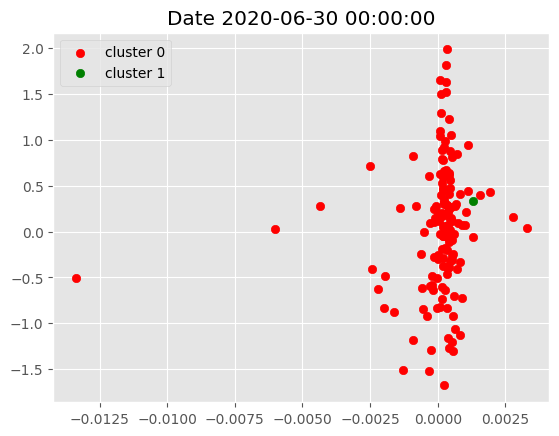

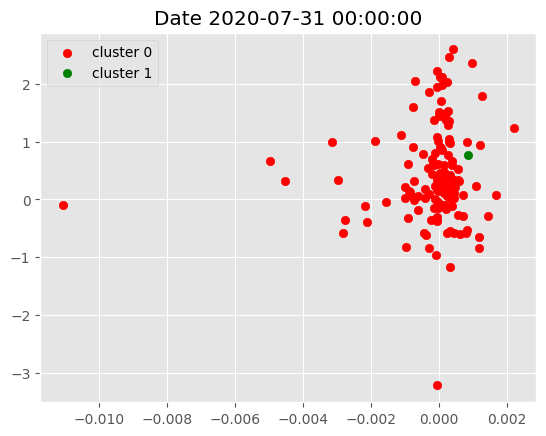

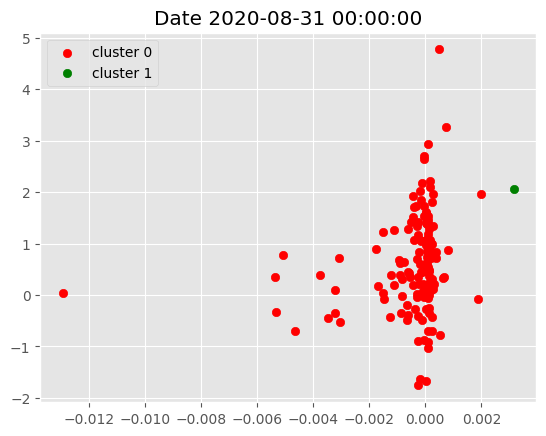

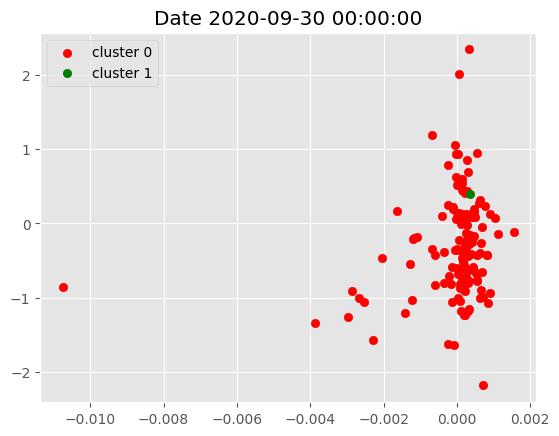

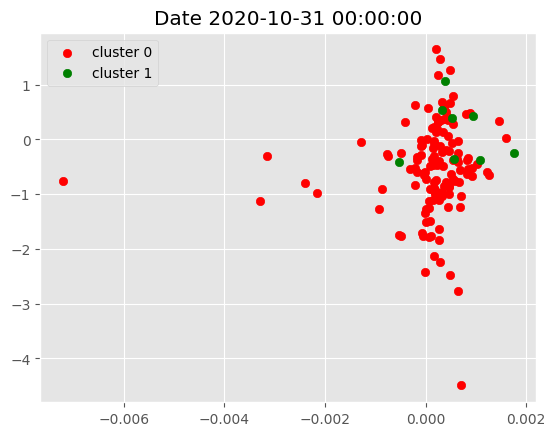

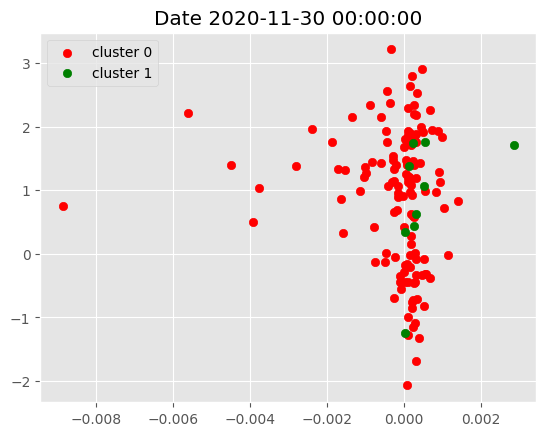

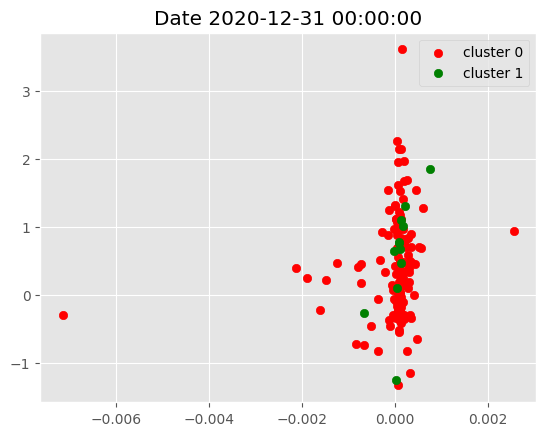

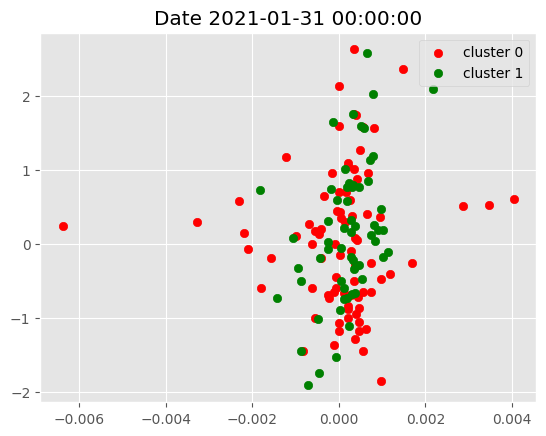

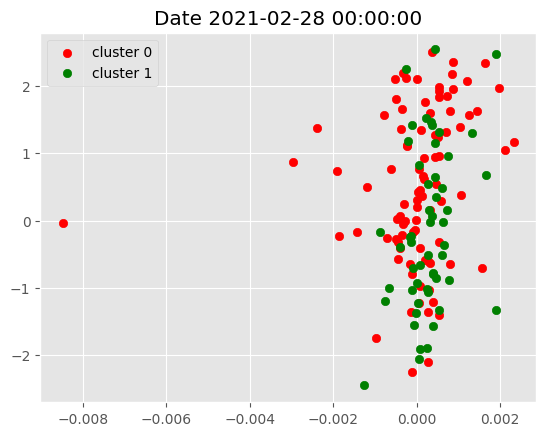

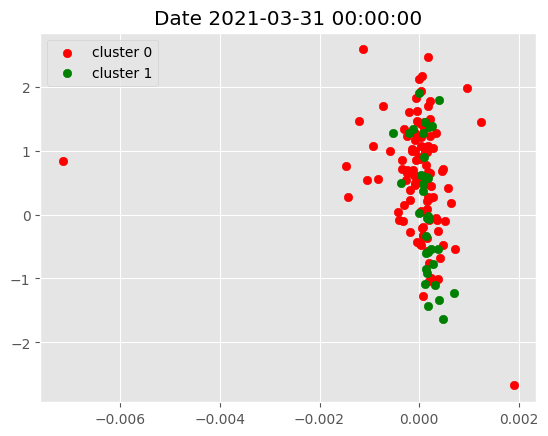

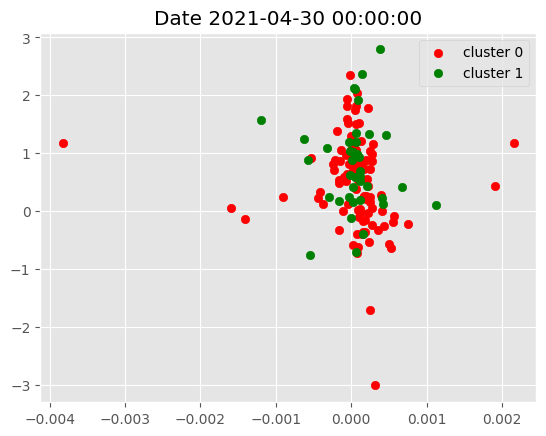

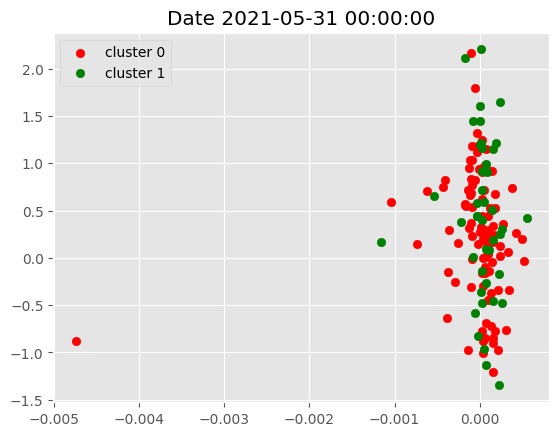

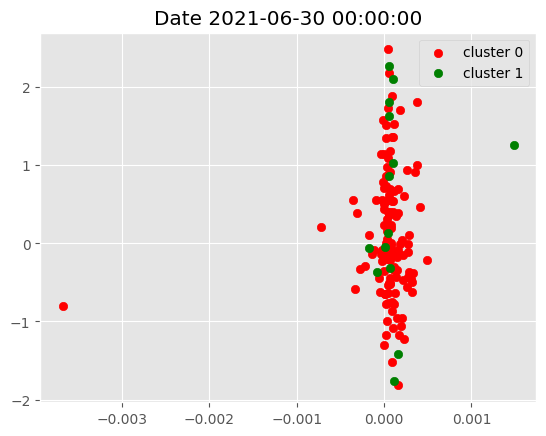

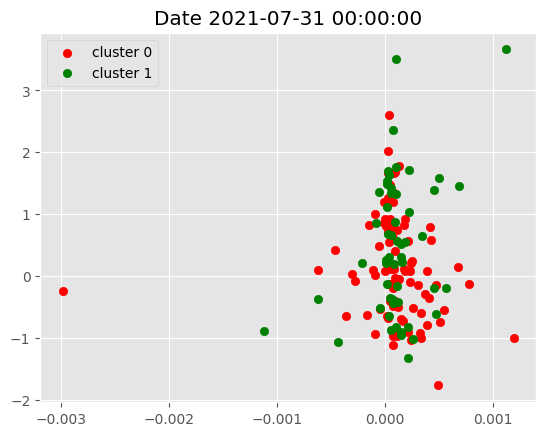

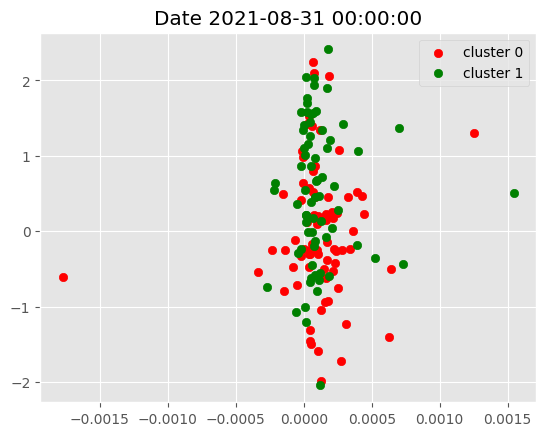

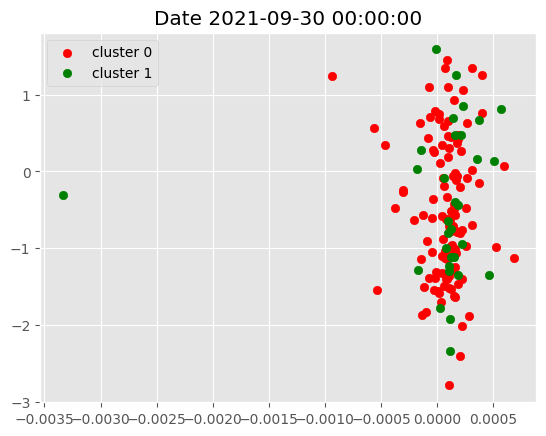

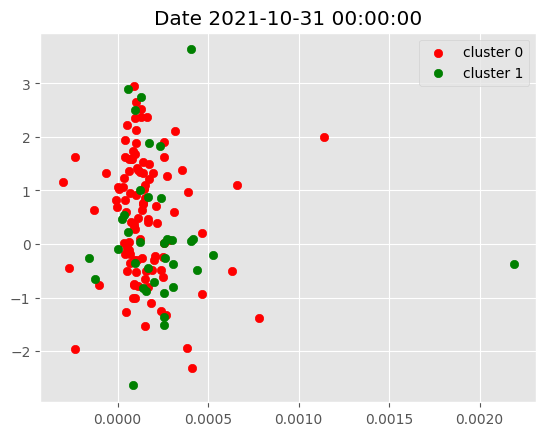

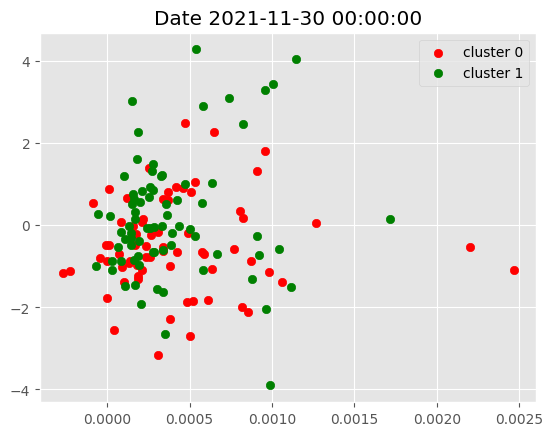

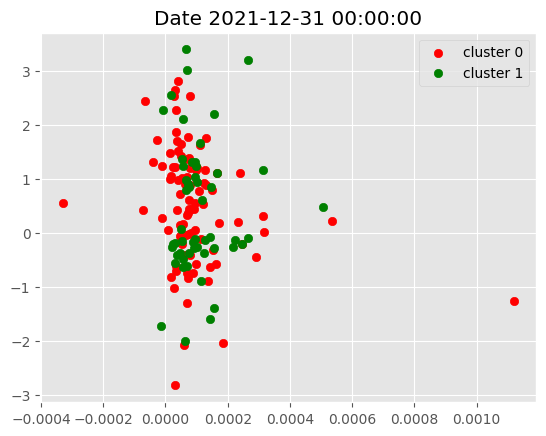

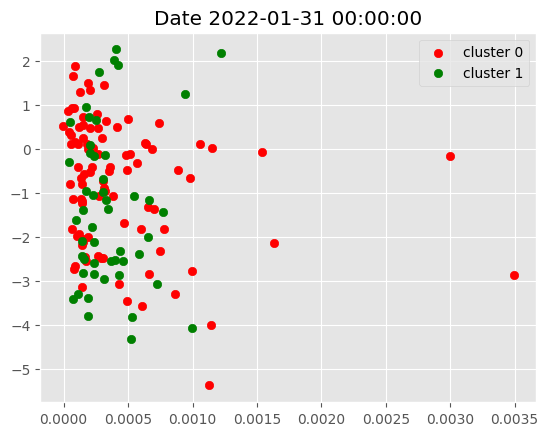

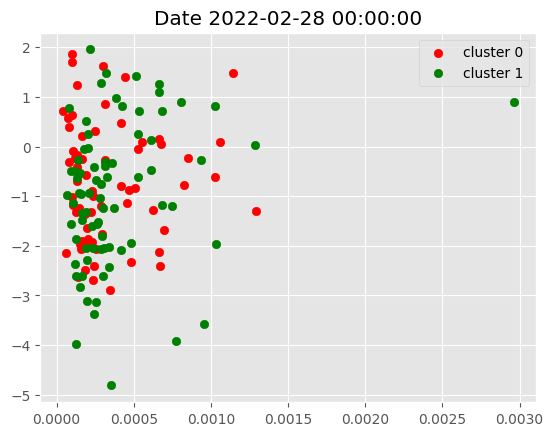

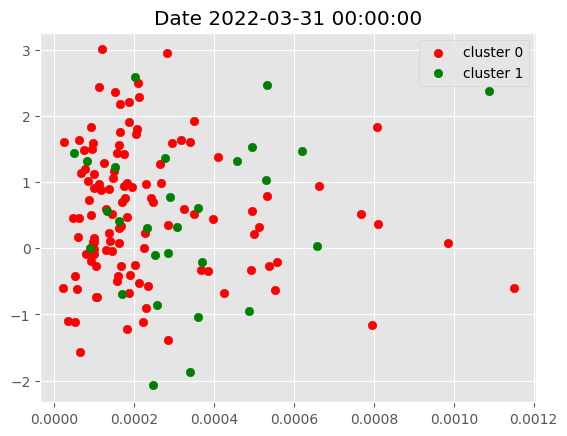

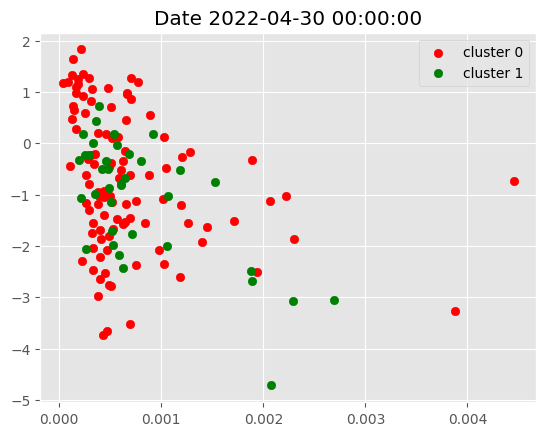

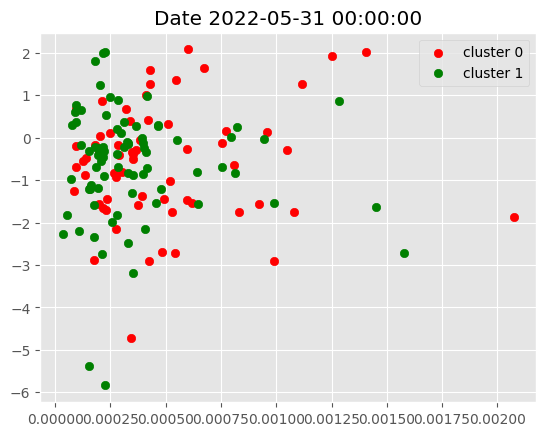

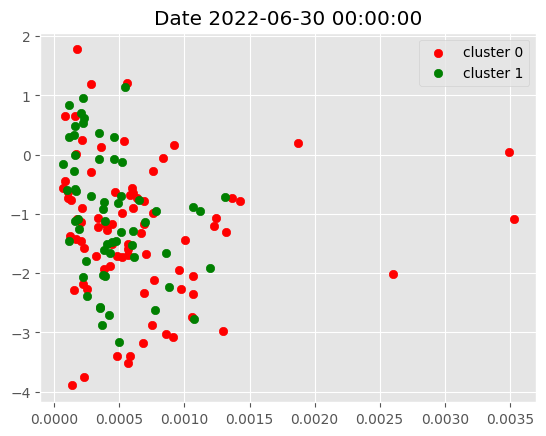

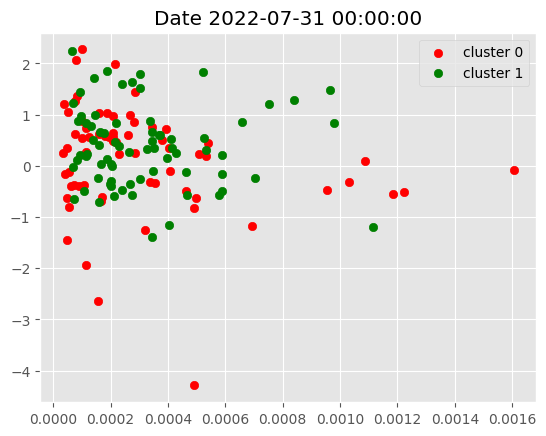

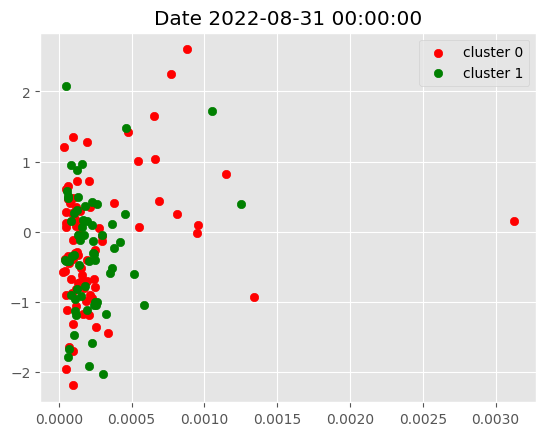

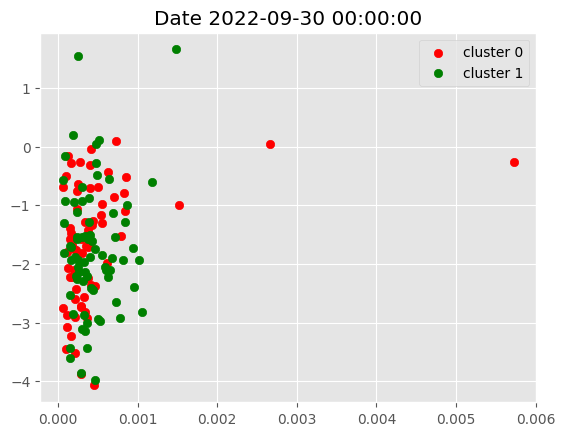

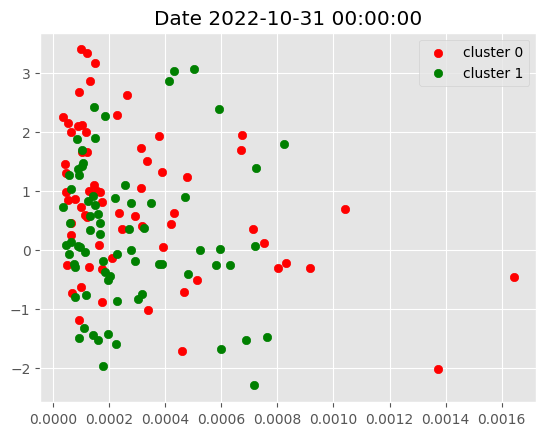

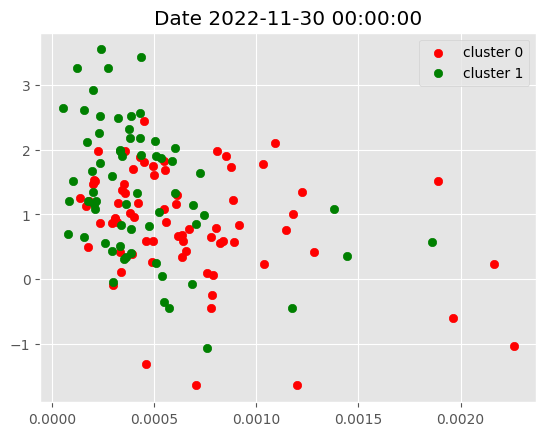

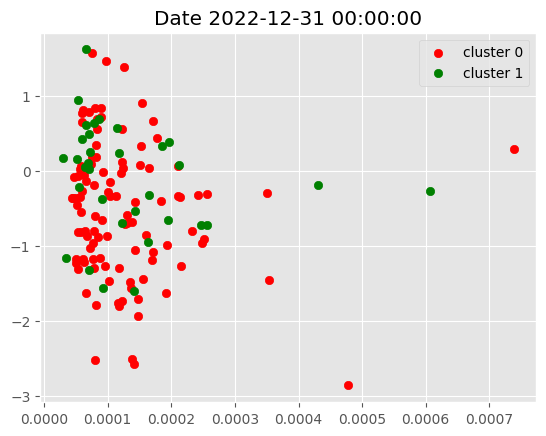

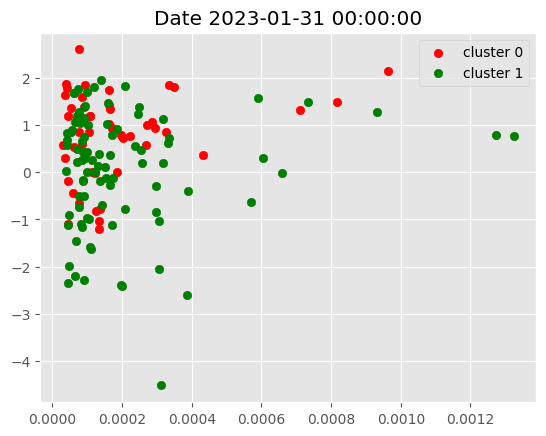

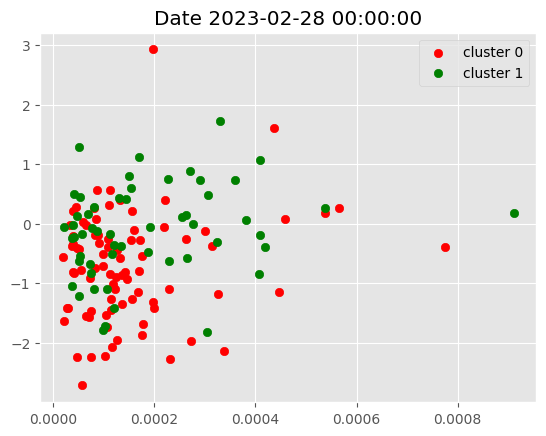

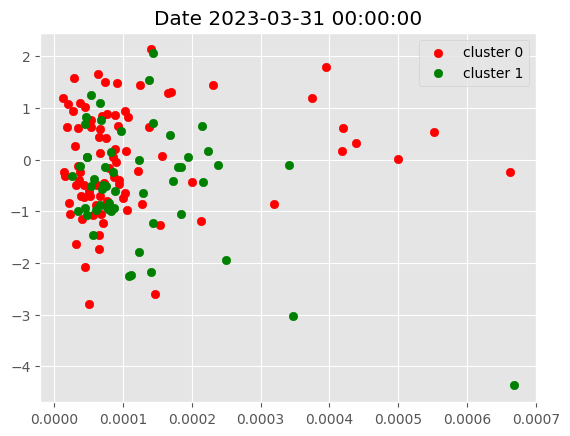

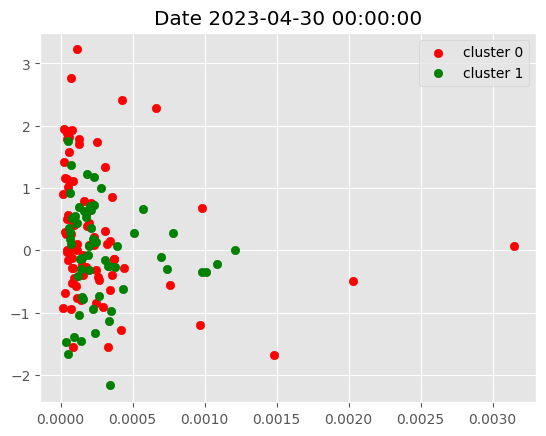

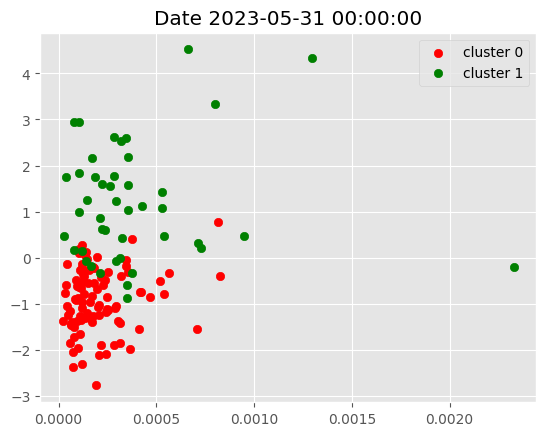

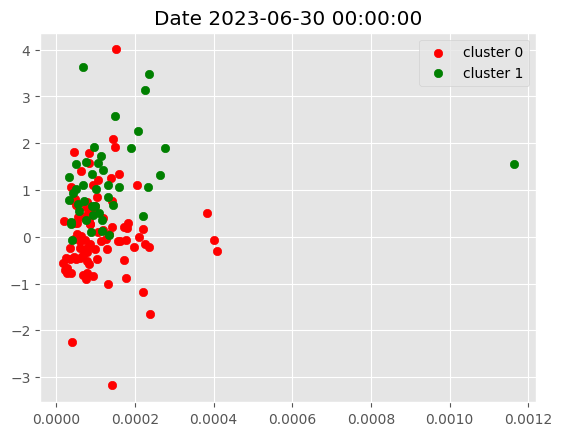

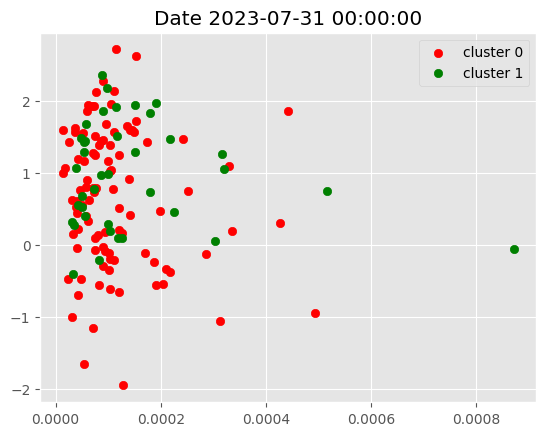

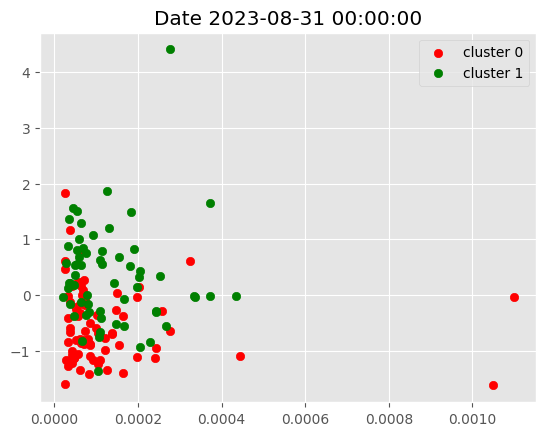

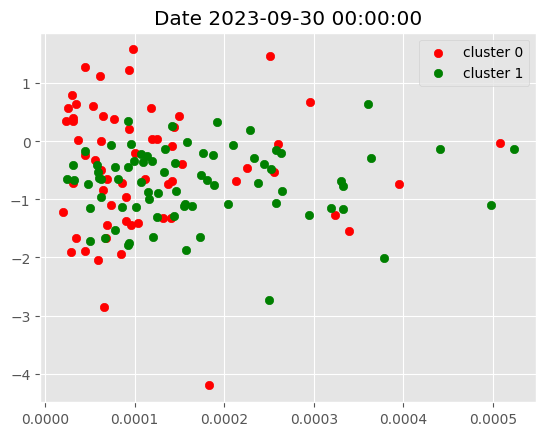

In [446]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    # cluster_2 = data[data['cluster']==2]
    # cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    # plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    # plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

### 7. For each month, select a set of assets based on the cluster and form a portfolio based on the Efficient Frontier max sharpe ratio optimization

In [447]:
# We select stocks from cluter 3 which are those with an RSI closer to 70 as our assumption is that momentum will keep on forward.
filtered_df = data[data['cluster']==1].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2017-11-01': ['AAPL',
  'ABBV',
  'ADBE',
  'AMZN',
  'AXP',
  'BA',
  'BAC',
  'BK',
  'CMG',
  'COP',
  'COST',
  'CRM',
  'CSCO',
  'CTSH',
  'CVS',
  'CVX',
  'DD',
  'EBAY',
  'EOG',
  'EXPE',
  'F',
  'FCX',
  'GOOG',
  'GOOGL',
  'GS',
  'HAL',
  'HUM',
  'INTC',
  'KHC',
  'KR',
  'LLY',
  'LOW',
  'MSFT',
  'MU',
  'NEM',
  'NFLX',
  'NKE',
  'NVDA',
  'ORLY',
  'OXY',
  'PANW',
  'PFE',
  'QCOM',
  'REGN',
  'RTX',
  'SCHW',
  'SLB',
  'TGT',
  'TSLA',
  'WFC',
  'XOM'],
 '2017-12-01': ['AAPL',
  'ABBV',
  'ADBE',
  'AMAT',
  'AMZN',
  'AXP',
  'BA',
  'BAC',
  'BK',
  'CMG',
  'COP',
  'COST',
  'CRM',
  'CSCO',
  'CTSH',
  'CVS',
  'CVX',
  'DD',
  'EBAY',
  'EOG',
  'EXPE',
  'F',
  'FCX',
  'GOOG',
  'GOOGL',
  'GS',
  'HAL',
  'HUM',
  'INTC',
  'ISRG',
  'KHC',
  'KR',
  'LLY',
  'LMT',
  'LOW',
  'MS',
  'MSFT',
  'MU',
  'NEM',
  'NFLX',
  'NKE',
  'NVDA',
  'ORCL',
  'ORLY',
  'OXY',
  'PANW',
  'PFE',
  'PNC',
  'QCOM',
  'REGN',
  'RTX',
  'SCHW',
  'SLB',
  'STZ

In [448]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models,expected_returns


def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  157 of 157 completed


Price       Adj Close                          ...    Volume                   
Ticker            AAL        AAPL        ABBV  ...       WMT     WYNN       XOM
Date                                           ...                             
2016-10-31  39.134323   26.660484   43.235226  ...  19167000  1341600  16663800
2016-11-01  38.363205   26.179125   43.754547  ...  26515800  3722300  13050600
2016-11-02  38.276459   26.202606   44.018085  ...  22935900  2542400  11226100
2016-11-03  38.054207   25.921747   43.320488  ...  20411700  9050400   8836500
2016-11-04  38.402084   25.688087   43.436756  ...  21786300  3223800  13877100
...               ...         ...         ...  ...       ...      ...       ...
2023-09-25  12.910000  176.080002  154.649994  ...  10459500  1387800  11316000
2023-09-26  12.700000  171.960007  153.910004  ...  14435700  1454000  11805400
2023-09-27  12.610000  170.429993  153.130005  ...  15711000  2050000  23976200
2023-09-28  12.920000  170.690002  152.250000  ...  11617200  1290400  16808100
2023-09-29  12.810000  171.210007  149.059998  ...  18842400  1326800  18810700

[1740 rows x 942 columns]

- calculate daily return for each stock from the fresh data
- then loop over each month start, select the stocks for the month and calculate their weights for the next month
- if the maximum sharpe ratio fails for a given month, apply equally-weighted weights
- calculate daily portfolio returns 

In [449]:
returns_dataframe = np.log(new_df['Adj Close']).diff()



portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]
        
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()
        temp_df.index.names = ['date', 'ticker']
        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df = portfolio_df.drop_duplicates()

Max Sharpe Optimization failed for 2019-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-12-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-12-01, Continuing with Equal-Weights
'return'


### 8. Visualise portfolio return and compare it to SP500 returns

In [450]:
# Compute returns of the SP500
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2017-11-01,0.004309,0.001321
2017-11-02,0.002735,0.000389
2017-11-03,0.003622,0.003333
2017-11-06,0.000882,0.001546
2017-11-07,0.003991,-0.000695
...,...,...
2023-09-25,0.002559,0.004196
2023-09-26,-0.012417,-0.014800
2023-09-27,0.005450,0.000399
2023-09-28,0.010758,0.005781


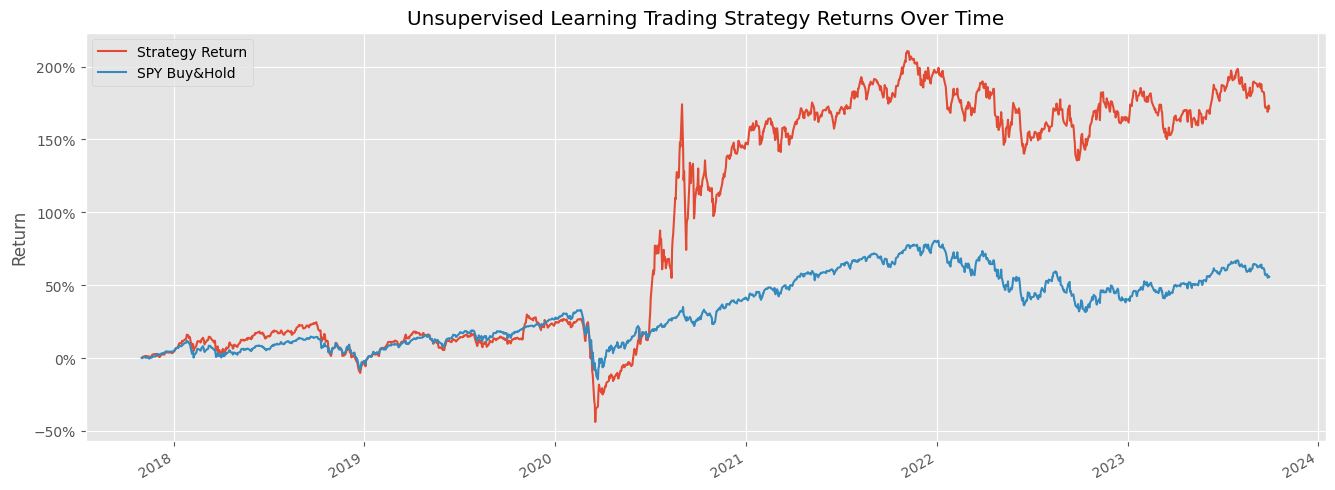

In [451]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()